In [3]:
import torch
import tqdm
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x
diffusion=Diffusion()


In [25]:
import cv2
import numpy
resim=cv2.imread("landscapes/00000000_(2).jpg",cv2.COLOR_BGR2RGB)
resim=cv2.resize(resim,(224,224))
resim=resim.reshape(3,224,224)
resim=torch.tensor(numpy.expand_dims(resim,axis=0),dtype=float).to("cuda")

In [26]:
images=resim

In [27]:
images.shape

torch.Size([1, 3, 224, 224])

In [30]:
cv2.imshow("resim",resim)

In [22]:
images=torch.rand(8,3,128,128).to("cuda")

In [28]:
t = diffusion.sample_timesteps(resim.shape[0]).to("cuda")
x_t, noise = diffusion.noise_images(resim, t)

IndexError: index 1 is out of bounds for dimension 0 with size 1

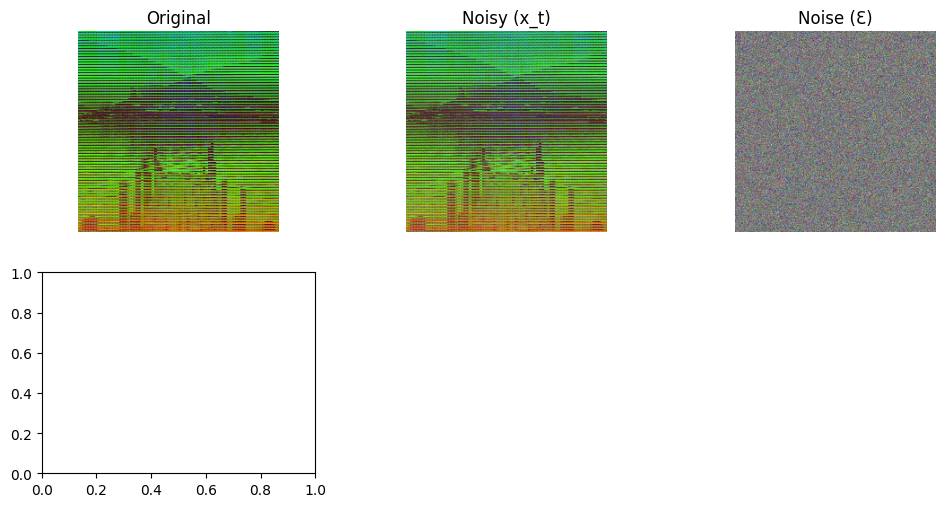

In [29]:
import matplotlib.pyplot as plt
def show_tensor_image(tensor):
    tensor = tensor.detach().cpu()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # normalize to [0,1]
    return tensor.permute(1, 2, 0).numpy()

# Görüntü ve noise'ları yan yana göster
def visualize_noisy_images(x, x_t, noise, num_images=4):
    plt.figure(figsize=(12, num_images * 3))

    for i in range(num_images):
        # Orijinal
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(show_tensor_image(x[i]))
        plt.title("Original")
        plt.axis("off")

        # Gürültülenmiş (x_t)
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(show_tensor_image(x_t[i]))
        plt.title("Noisy (x_t)")
        plt.axis("off")

        # Gürültü (noise)
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(show_tensor_image(noise[i]))
        plt.title("Noise (Ɛ)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Örnek kullanımı
visualize_noisy_images(images, x_t, noise)

In [30]:
noise.shape

torch.Size([1, 3, 224, 224])

In [25]:
x_t.shape

torch.Size([8, 3, 128, 128])

In [17]:
images=torch.rand(8,3,128,128)

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnaud58/landscape-pictures")

print("Path to dataset files:", path)

c:\Users\bahaa\anaconda3\envs\altantorch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\bahaa\.cache\kagglehub\datasets\arnaud58\landscape-pictures\versions\2


In [15]:
from torch import nn
from torch.nn import functional as F

In [16]:
class SelfAttention(nn.Module):
    def __init__(self, channels, heads):
        super().__init__()
        assert channels % heads == 0
        self.n_head = heads
        self.n_embd = channels  # burada n_embd = channels = C
        self.c_attn = nn.Linear(channels, 3 * channels)
        self.c_proj = nn.Linear(channels, channels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x: [B, C, H, W] --> önce [B, H*W, C] formatına getir
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).transpose(1, 2)  # -> [B, T=H*W, C]

        B, T, C = x.size()  # B, T, C = [32, 4096, 128] gibi olur

        qkv = self.c_attn(x)  # -> [B, T, 3C]
        q, k, v = qkv.split(self.n_embd, dim=2)  # her biri [B, T, C]

        # reshape to [B, nh, T, hs]
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # attention
        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)  # CNN için causality gerekmez
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # [B, T, C]

        # output proj + dropout
        y = self.dropout(self.c_proj(y))

        # tekrar orijinal boyuta getir: [B, C, H, W]
        y = y.transpose(1, 2).view(B, C, H, W)
        return y


In [17]:
import torch

In [20]:
x = torch.randn(32, 256, 32,32).cuda()

# Attention bloğu oluştur
attention = SelfAttention(256,4).cuda()

# Forward geçiş
out = attention(x)
print(out.shape)  # torch.Size([32, 128, 64, 64])

torch.Size([32, 256, 32, 32])


In [8]:
x_reshaped = torch.rand(32,128,64,64).view(32, 128, 64*64).transpose(1, 2)

In [10]:
x_reshaped.shape

torch.Size([32, 4096, 128])